<a href="https://colab.research.google.com/github/aavelinee/Bias-in-Recidivism-Prediction-Instruments/blob/main/Fair_Prediction_with_Disparate_Impact_A_Study_of_Bias_in_Recidivism_Prediction_Instruments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Load the COMPAS dataset, the CSV file 'compas-scores-two-years.csv'

In [2]:
data = pd.read_csv('compas-scores-two-years.csv')

Filter for African-American and Caucasian defendants

In [3]:
data = data[(data['race'] == 'African-American') | (data['race'] == 'Caucasian')]

Defining whether the person is recidivated or not and if they are categorized as high risk or not base on their score.

In [4]:
data['is_recid'] = data['two_year_recid'].map({0: 0, 1: 1})
data['is_high_risk'] = (data['decile_score'] > 4).astype(int)

In [5]:
data['is_black'] = (data['race'] == 'African-American').astype(int)

In [6]:
len(data)

6150

In [7]:
data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,is_high_risk,is_black
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,0,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,2013-01-13,NaN,NaN,1,0,1174,0,0,1,1
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1,1,0
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0,0,0


**Error Rate Balance Analysis**

ppv: positive predictive value

fpr: false positive rate

fnr: false negative rate

computing different metrics for each racial group


In [8]:
def calculate_ppv(y_true, y_pred):
    return np.mean(y_true[y_pred == 1])

def calculate_fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

def calculate_fnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

def fairness_metrics(data, group_col, outcome_col, prediction_col):
    metrics = {}
    for group in data[group_col].unique():
        group_data = data[data[group_col] == group]
        y_true = group_data[outcome_col]
        y_pred = group_data[prediction_col]
        metrics[group] = {
            'PPV': calculate_ppv(y_true, y_pred),
            'FPR': calculate_fpr(y_true, y_pred),
            'FNR': calculate_fnr(y_true, y_pred)
        }
    return metrics

For the thresholds range, we predict the risk and calculate the metrics (ppv, fpr, and fnr) and we plot them.

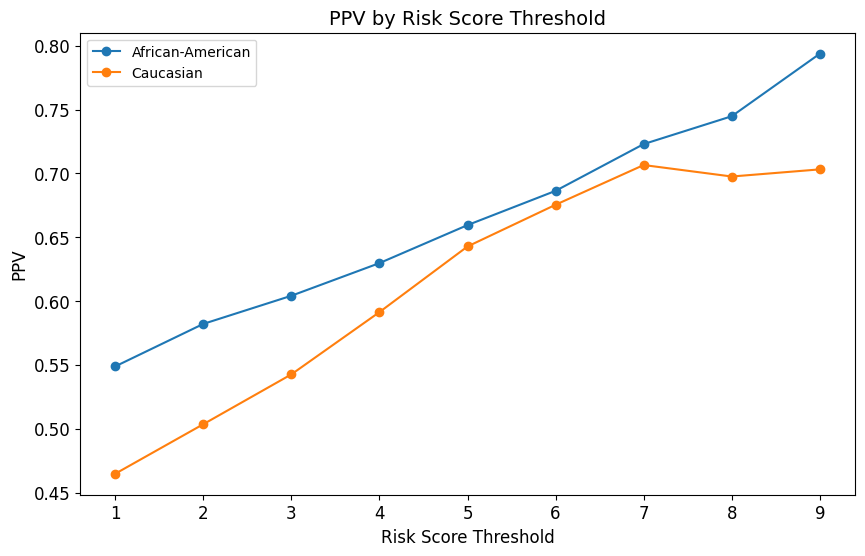

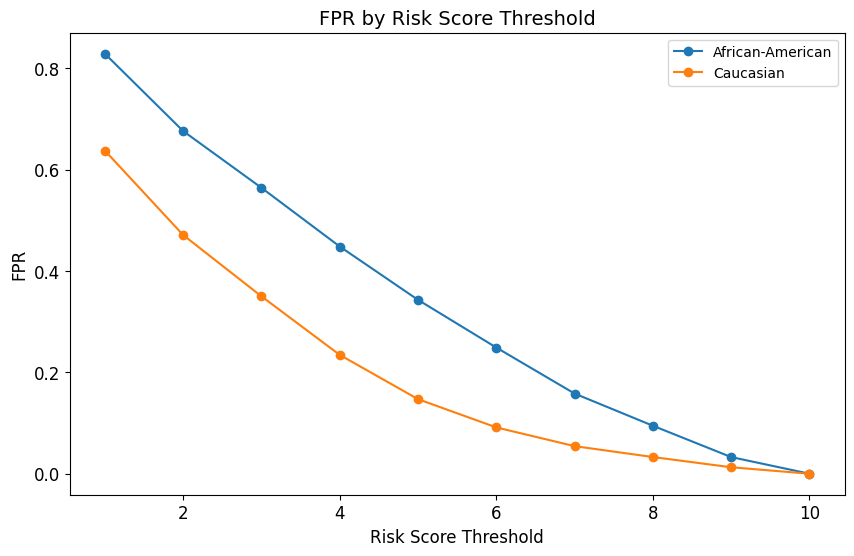

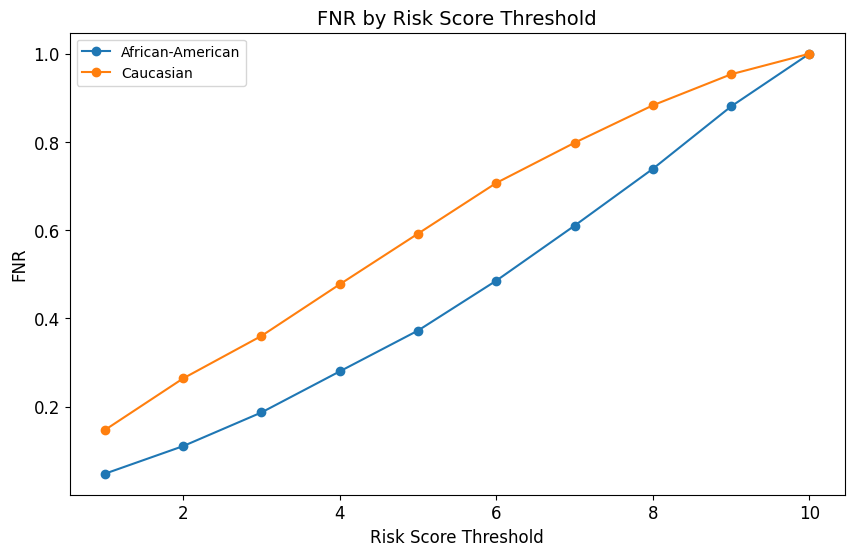

In [16]:
thresholds = range(1, 11)
metrics_by_threshold = {}

for threshold in thresholds:
    data['prediction'] = (data['decile_score'] > threshold).astype(int)
    metrics_by_threshold[threshold] = fairness_metrics(data, 'race', 'two_year_recid', 'prediction')

def plot_metric_by_threshold(metric):
    plt.figure(figsize=(10, 6))
    for race in ['African-American', 'Caucasian']:
        values = [metrics_by_threshold[t][race][metric] for t in thresholds]
        plt.plot(thresholds, values, marker='o', label=race)
    plt.xlabel('Risk Score Threshold', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.title(f'{metric} by Risk Score Threshold', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()
    plt.show()

plot_metric_by_threshold('PPV')
plot_metric_by_threshold('FPR')
plot_metric_by_threshold('FNR')

**Calibration Analysis**

we now here plot the calibration criterion for COMPAS based on the scores.

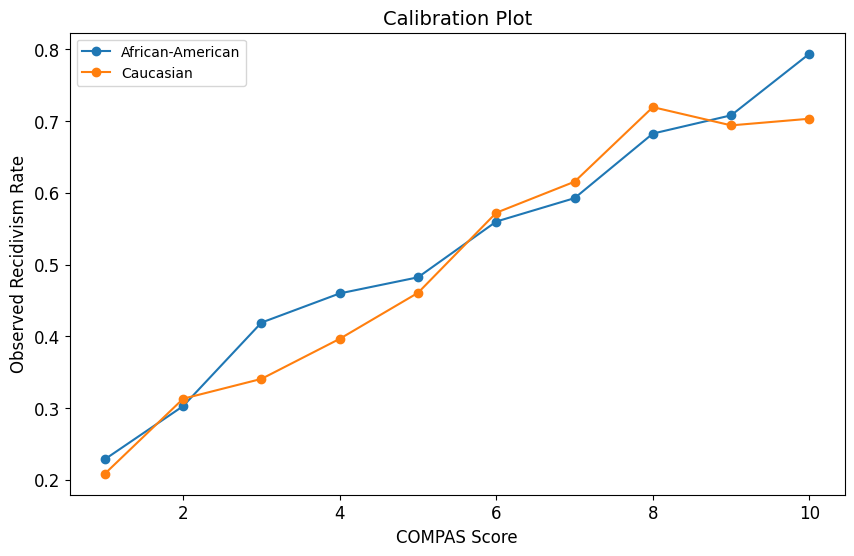

In [17]:
def plot_calibration(data, race):
    race_data = data[data['race'] == race]
    observed_recid = race_data.groupby('decile_score')['is_recid'].mean()
    plt.plot(observed_recid.index, observed_recid.values, marker='o', label=race)
    plt.xlabel('COMPAS Score', fontsize=12)
    plt.ylabel('Observed Recidivism Rate', fontsize=12)
    plt.title('Calibration Plot', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.figure(figsize=(10, 6))
plot_calibration(data, 'African-American')
plot_calibration(data, 'Caucasian')
plt.legend()
plt.show()

**Predictive Parity and Error Rate Analysis**

In [18]:
print(data['race'].value_counts())
print(data['two_year_recid'].value_counts())
print(data['decile_score'].value_counts())

race
African-American    3696
Caucasian           2454
Name: count, dtype: int64
two_year_recid
0    3283
1    2867
Name: count, dtype: int64
decile_score
1     1079
2      754
4      670
3      619
5      606
6      578
7      543
9      478
8      473
10     350
Name: count, dtype: int64


In [19]:
data.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid', 'is_high_risk', 'is_black',
       'prediction'],
      dtype='object')

In [20]:
print(data['r_charge_degree'].unique())

['(F3)' '(M1)' nan '(F2)' '(M2)' '(MO3)' '(F1)' '(F6)' '(F7)' '(CO3)']


In order to have a better and neater data, we changed the nan items to 'Unknown' and omitted the parenthesis.

In [21]:
data['r_charge_degree'] = data['r_charge_degree'].str.strip('()').fillna('Unknown')
print(data['r_charge_degree'].unique())

['F3' 'M1' 'Unknown' 'F2' 'M2' 'MO3' 'F1' 'F6' 'F7' 'CO3']


In [22]:
print(data['r_charge_degree'].value_counts())
print(data.groupby(['race', 'two_year_recid', 'r_charge_degree']).size())

r_charge_degree
Unknown    3089
M1         1064
M2          951
F3          803
F2          150
F1           44
MO3          38
F7            6
F6            3
CO3           2
Name: count, dtype: int64
race              two_year_recid  r_charge_degree
African-American  0               F1                    1
                                  F2                    4
                                  F3                   38
                                  M1                   51
                                  M2                   40
                                  MO3                   1
                                  Unknown            1660
                  1               CO3                   1
                                  F1                   35
                                  F2                  110
                                  F3                  482
                                  F6                    3
                                  F7                

**Average Sentence under Different Policies**

We implemented MinMax and Interpolation policies and plotted the average sentences duration based on the severity of the punishment (COMPASS scores).
Based on the information provided in the paper, the tmin and tmax values of 0 and 36 months respectively were chosen to approximate the sentencing guidelines used in Pennsylvania.

In [23]:
def minmax_policy(score, tmin, tmax):
    return tmin if score <= 4 else tmax

def interpolation_policy(score, tmin, tmax):
    return tmin + (score - 1) / 9 * (tmax - tmin)

def plot_average_sentences(data, policy_col):
    plt.figure(figsize=(12, 6))
    charge_degrees = ['M2', 'M1', 'F3', 'F2', 'F1']  # Focus on these main categories

    for recid in [0, 1]:
        for race in ['African-American', 'Caucasian']:
            avg_sentences = []
            for degree in charge_degrees:
                subset = data[(data['two_year_recid'] == recid) &
                              (data['race'] == race) &
                              (data['r_charge_degree'] == degree)]
                if len(subset) > 0:
                    avg_sentences.append(subset[policy_col].mean())
                else:
                    avg_sentences.append(np.nan)

            plt.plot(charge_degrees, avg_sentences, marker='o',
                     linestyle='-' if recid == 1 else '--',
                     label=f"{race}, Recid={'Yes' if recid == 1 else 'No'}")

    plt.xlabel('Charge Degree', fontsize=12)
    plt.ylabel('Average Sentence Duration (months)', fontsize=12)
    plt.title(f'Average Sentences under {policy_col} Policy', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

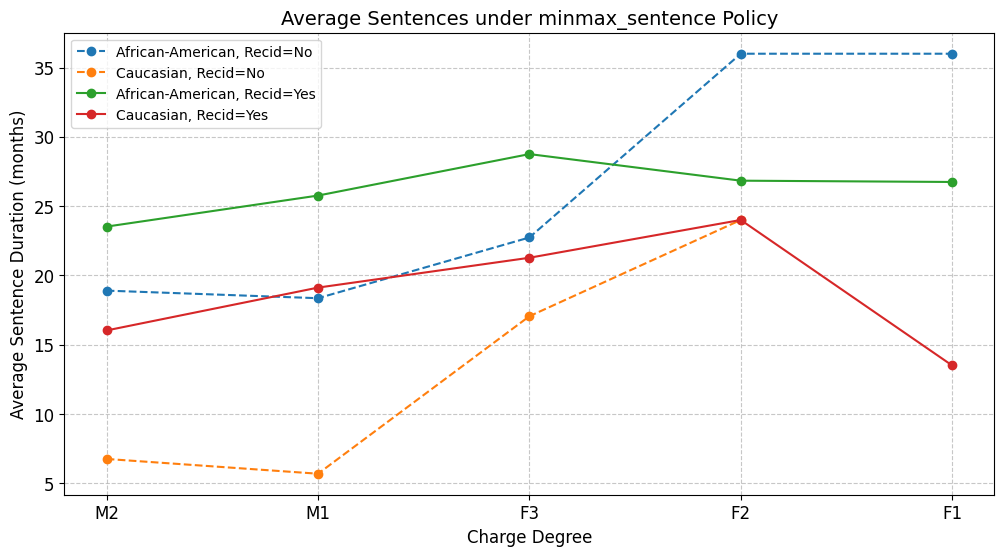

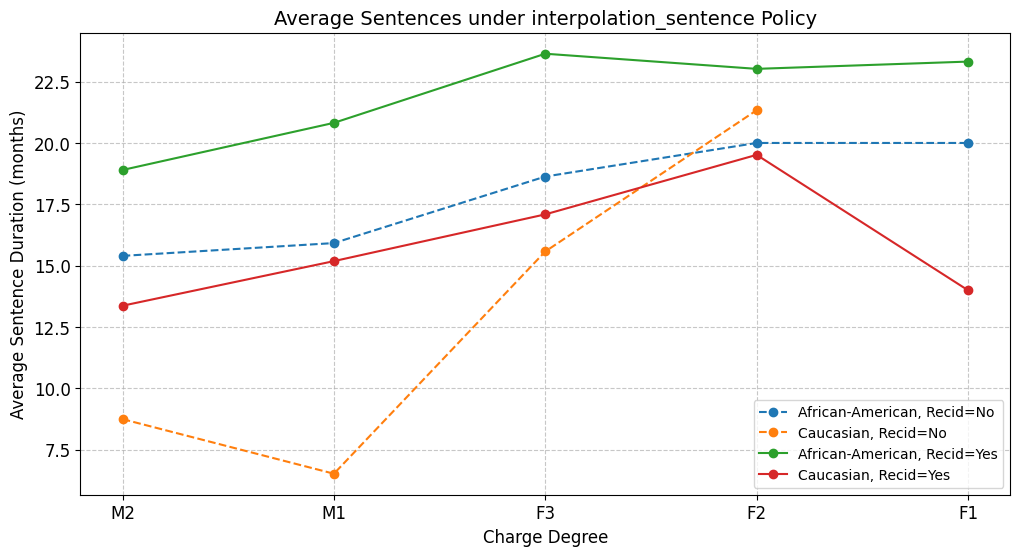

In [24]:
tmin, tmax = 0, 36

data['minmax_sentence'] = data['decile_score'].apply(lambda x: minmax_policy(x, tmin, tmax))
data['interpolation_sentence'] = data['decile_score'].apply(lambda x: interpolation_policy(x, tmin, tmax))

plot_average_sentences(data, 'minmax_sentence')
plot_average_sentences(data, 'interpolation_sentence')

**Gender Differences in COMPAS Scores**

Now I would like to experiment on the gender of the defendants. First, let's look at the distribution of the data across race and sex categories:

This will give us an idea of the sample sizes for each subgroup. The number of the male defendants are more than women.

In [25]:
print(data.groupby(['race', 'sex']).size())

race              sex   
African-American  Female     652
                  Male      3044
Caucasian         Female     567
                  Male      1887
dtype: int64


Now we calculate recidivism rates for each race-sex combination

In [26]:
recidivism_rates = data.groupby(['race', 'sex'])['two_year_recid'].mean()
print(recidivism_rates)

race              sex   
African-American  Female    0.378834
                  Male      0.543364
Caucasian         Female    0.350970
                  Male      0.406465
Name: two_year_recid, dtype: float64


COMPAS Score Distribution

In [27]:
score_distribution = data.groupby(['race', 'sex'])['decile_score'].describe()
print(score_distribution)

                          count      mean       std  min  25%  50%  75%   max
race             sex                                                         
African-American Female   652.0  4.757669  2.689717  1.0  2.0  5.0  7.0  10.0
                 Male    3044.0  5.499671  2.843896  1.0  3.0  6.0  8.0  10.0
Caucasian        Female   567.0  3.897707  2.641764  1.0  1.0  3.0  6.0  10.0
                 Male    1887.0  3.686275  2.583317  1.0  1.0  3.0  5.0  10.0


False Positive and False Negative Rates for threshold = 4

In [28]:
def calculate_fpr(group):
    return ((group['decile_score'] > 4) & (group['two_year_recid'] == 0)).mean()
fpr = data.groupby(['race', 'sex']).apply(calculate_fpr)
print(fpr)

race              sex   
African-American  Female    0.251534
                  Male      0.210578
Caucasian         Female    0.195767
                  Male      0.126126
dtype: float64


In [29]:
def calculate_fnr(group):
    return ((group['decile_score'] <= 4) & (group['two_year_recid'] == 1)).mean()

fnr = data.groupby(['race', 'sex']).apply(calculate_fnr)
print("False Negative Rates:")
print(fnr)

False Negative Rates:
race              sex   
African-American  Female    0.113497
                  Male      0.150460
Caucasian         Female    0.151675
                  Male      0.198728
dtype: float64


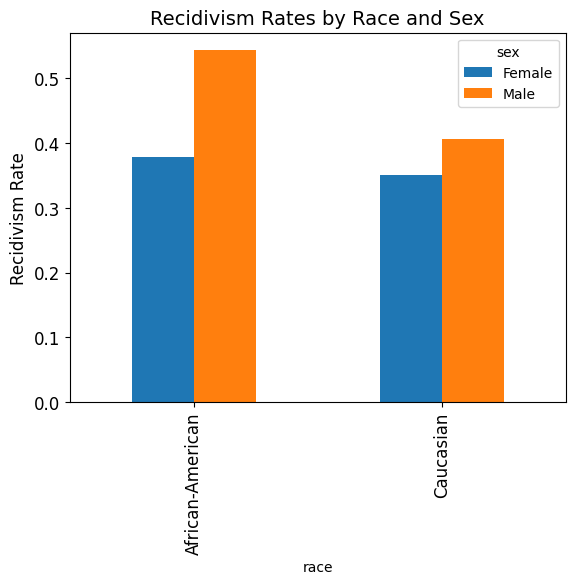

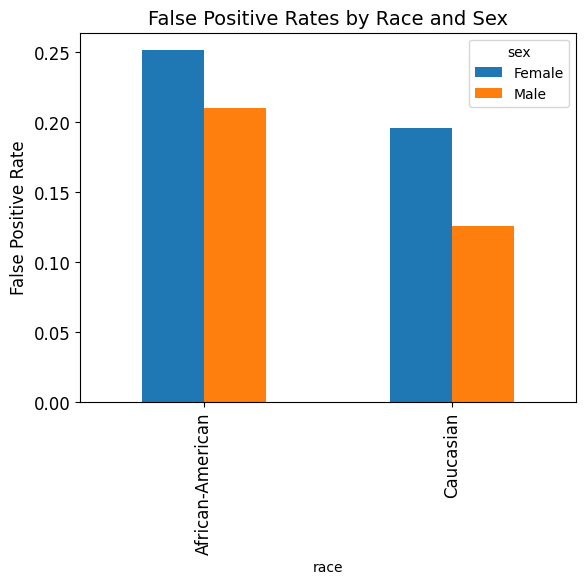

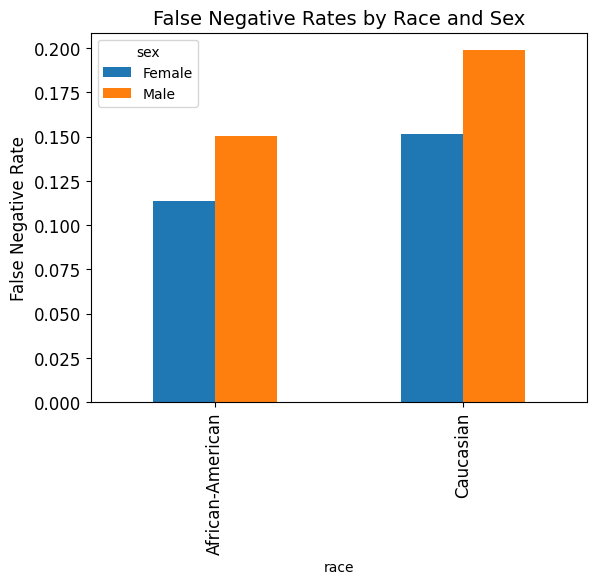

In [32]:
# Recidivism rates
recidivism_rates.unstack().plot(kind='bar')
plt.title('Recidivism Rates by Race and Sex', fontsize=14)
plt.ylabel('Recidivism Rate', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# False Positive Rates
fpr.unstack().plot(kind='bar')
plt.title('False Positive Rates by Race and Sex', fontsize=14)
plt.ylabel('False Positive Rate', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# False Negative Rates
fnr.unstack().plot(kind='bar')
plt.title('False Negative Rates by Race and Sex', fontsize=14)
plt.ylabel('False Negative Rate', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

We now perform chi-square tests to check if the differences between groups are statistically significant.
Since p-value is extremely small (2.46e-32), we can say that the differences are highly unlikely to occur by chance and the result is highly significant.
Also the large chi-square value (150.14) suggests substantial differences between the observed frequencies and what we would expect if there was no association between race, sex, and recidivism.
It means that these results provide strong evidence that there is a meaningful relationship between an individual's race, sex, and their likelihood of recidivism in our dataset.

In [31]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(data['race'] + '_' + data['sex'], data['two_year_recid'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")

Chi-square statistic: 150.13994788660972
p-value: 2.4579723339950338e-32
